In [1]:
# coding: utf-8
import os

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from mydatools.features_analyze import get_top_k_corr

% matplotlib inline

## Config

In [2]:
trn_path = './data/input/train.csv'
tst_path = './data/input/test.csv'
id_col = 'id'
label_col = 'target'

submission_path = './data/output/submission.csv'
output_id_col = id_col
output_label_col = label_col

## Load Data

In [3]:
trn_df = pd.read_csv(trn_path)
trn_df['ds_type'] = 'train'

tst_df = pd.read_csv(tst_path)
tst_df['ds_type'] = 'test'

full_df = pd.concat([trn_df, tst_df])

del(trn_df)
del(tst_df)

full_df.head()

,ds_type,id,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,...,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,target
0,train,7,0.6,0.5,0.2,3,1,10,1,10,...,0,0,11,0,1,0,0.7,0.2,0.718070,0.0
1,train,9,0.3,0.1,0.3,2,1,9,5,8,...,0,0,3,0,0,1,0.8,0.4,0.766078,0.0
2,train,13,0.5,0.7,0.1,2,2,9,1,8,...,0,0,12,1,0,0,0.0,0.0,-1.000000,0.0
3,train,16,0.6,0.9,0.1,2,4,7,1,8,...,0,0,8,1,0,0,0.9,0.2,0.580948,0.0
4,train,17,0.4,0.6,0.0,2,2,6,3,10,...,0,0,9,1,0,0,0.7,0.6,0.840759,0.0


In [4]:
# dataset type
is_train = full_df['ds_type'] == 'train'
is_test = full_df['ds_type'] == 'test'

## Features

In [5]:
a = [11,22,33,44]
a.remove(33)
33 in a

False

In [6]:
feature_columns = []

def add_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])
    
def remove_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns = [f for f in feature_columns if f not in features]

In [7]:
numerical_features = full_df.dtypes[full_df.dtypes != 'object'].index.tolist()
numerical_features = [c for c in numerical_features if c not in [id_col, label_col, 'ds_type']]
add_features(numerical_features)

* 空值处理

In [8]:
full_df.replace(-1, np.nan, inplace=True)

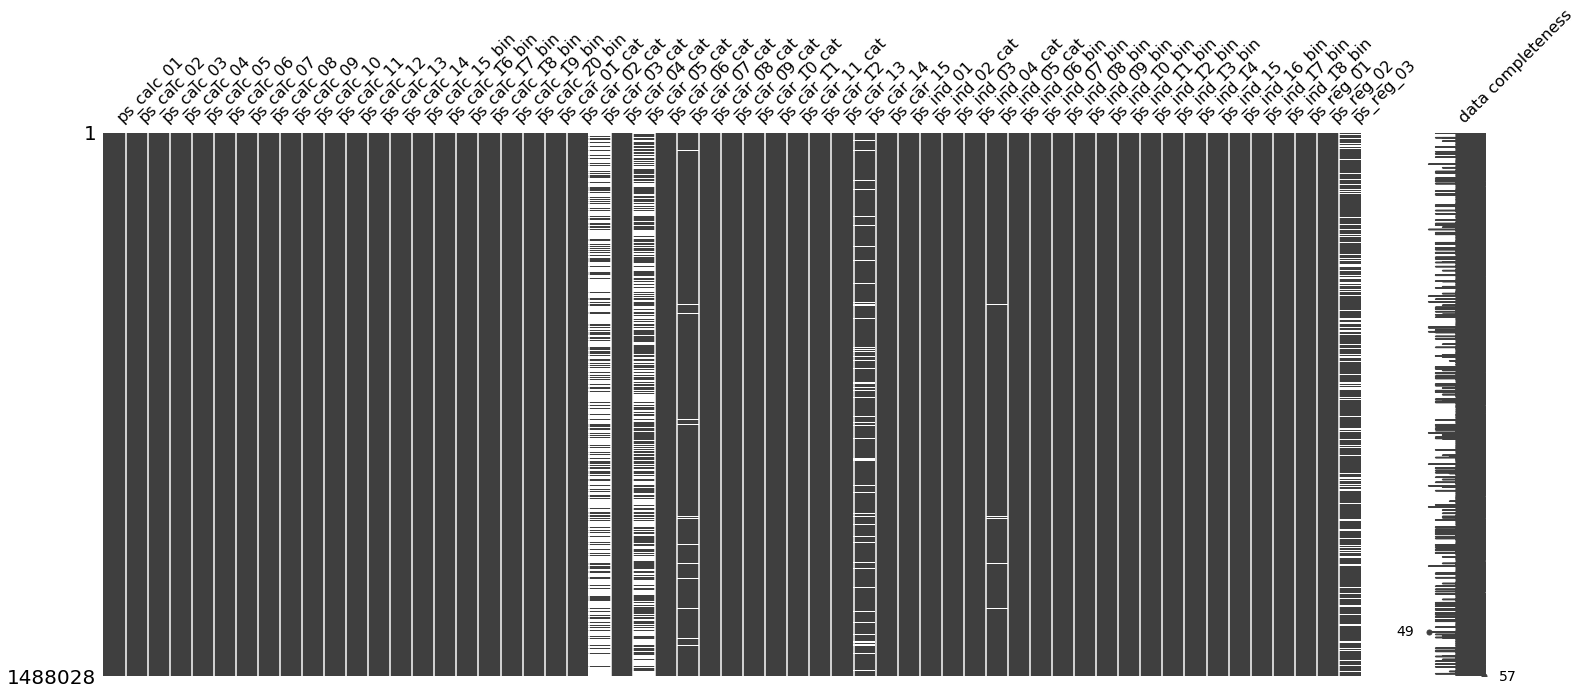

In [9]:
import missingno as msno
msno.matrix(full_df[feature_columns], labels=True)

* 处理categorical类型特征

In [10]:
categorical_features = [c for c in feature_columns if c.endswith('cat')]

In [11]:
dummy_df = pd.get_dummies(full_df[categorical_features], columns=categorical_features)
remove_features(categorical_features)
add_features(dummy_df.columns.tolist())
full_df[dummy_df.columns] = dummy_df

## LightGBM

In [12]:
trn_df = full_df[is_train]
tst_df = full_df[is_test]

X = trn_df[feature_columns]
y = trn_df[label_col]
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_tst = tst_df[feature_columns]

trn_lgb = lgb.Dataset(X_trn.values, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val.values, y_val, free_raw_data=False, reference=trn_lgb)

* gini coef

In [13]:
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

* train

In [14]:
params = {
    'application': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.02,
    'is_unbalance': True,
#     'max_depth': 5,
#     'num_leaves': 25,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
#     'reg_alpha': 0.1,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, 
                valid_sets=[trn_lgb, val_lgb], 
                early_stopping_rounds=20, 
                feval=gini_lgb)

[1]	training's binary_logloss: 0.692434	training's gini: 0.215012	valid_1's binary_logloss: 0.69247	valid_1's gini: 0.164838
Training until validation scores don't improve for 20 rounds.
[2]	training's binary_logloss: 0.691682	training's gini: 0.248777	valid_1's binary_logloss: 0.69173	valid_1's gini: 0.198452
[3]	training's binary_logloss: 0.691033	training's gini: 0.258356	valid_1's binary_logloss: 0.691107	valid_1's gini: 0.203015
[4]	training's binary_logloss: 0.690286	training's gini: 0.264013	valid_1's binary_logloss: 0.69039	valid_1's gini: 0.208449
[5]	training's binary_logloss: 0.68962	training's gini: 0.269968	valid_1's binary_logloss: 0.689731	valid_1's gini: 0.219577
[6]	training's binary_logloss: 0.688863	training's gini: 0.274517	valid_1's binary_logloss: 0.688988	valid_1's gini: 0.223376
[7]	training's binary_logloss: 0.688139	training's gini: 0.276355	valid_1's binary_logloss: 0.68829	valid_1's gini: 0.22366
[8]	training's binary_logloss: 0.687528	training's gini: 0.279

[66]	training's binary_logloss: 0.666022	training's gini: 0.300818	valid_1's binary_logloss: 0.667019	valid_1's gini: 0.24286
[67]	training's binary_logloss: 0.665829	training's gini: 0.301217	valid_1's binary_logloss: 0.666841	valid_1's gini: 0.243071
[68]	training's binary_logloss: 0.665629	training's gini: 0.30149	valid_1's binary_logloss: 0.666662	valid_1's gini: 0.242967
[69]	training's binary_logloss: 0.665416	training's gini: 0.302026	valid_1's binary_logloss: 0.666459	valid_1's gini: 0.243467
[70]	training's binary_logloss: 0.665198	training's gini: 0.302257	valid_1's binary_logloss: 0.666253	valid_1's gini: 0.24357
[71]	training's binary_logloss: 0.665012	training's gini: 0.302536	valid_1's binary_logloss: 0.666074	valid_1's gini: 0.243807
[72]	training's binary_logloss: 0.664806	training's gini: 0.302959	valid_1's binary_logloss: 0.665884	valid_1's gini: 0.244208
[73]	training's binary_logloss: 0.66464	training's gini: 0.303092	valid_1's binary_logloss: 0.665734	valid_1's gin

[131]	training's binary_logloss: 0.656472	training's gini: 0.321614	valid_1's binary_logloss: 0.658189	valid_1's gini: 0.25122
[132]	training's binary_logloss: 0.656344	training's gini: 0.322043	valid_1's binary_logloss: 0.658064	valid_1's gini: 0.2515
[133]	training's binary_logloss: 0.65623	training's gini: 0.322415	valid_1's binary_logloss: 0.657957	valid_1's gini: 0.251689
[134]	training's binary_logloss: 0.656126	training's gini: 0.322735	valid_1's binary_logloss: 0.657863	valid_1's gini: 0.251746
[135]	training's binary_logloss: 0.656035	training's gini: 0.32293	valid_1's binary_logloss: 0.657784	valid_1's gini: 0.251734
[136]	training's binary_logloss: 0.655942	training's gini: 0.323181	valid_1's binary_logloss: 0.657703	valid_1's gini: 0.251739
[137]	training's binary_logloss: 0.655821	training's gini: 0.323554	valid_1's binary_logloss: 0.657588	valid_1's gini: 0.251973
[138]	training's binary_logloss: 0.655715	training's gini: 0.323864	valid_1's binary_logloss: 0.657489	valid_

[196]	training's binary_logloss: 0.650588	training's gini: 0.340847	valid_1's binary_logloss: 0.652908	valid_1's gini: 0.256769
[197]	training's binary_logloss: 0.650507	training's gini: 0.34114	valid_1's binary_logloss: 0.652846	valid_1's gini: 0.256761
[198]	training's binary_logloss: 0.650429	training's gini: 0.341401	valid_1's binary_logloss: 0.652771	valid_1's gini: 0.256981
[199]	training's binary_logloss: 0.650366	training's gini: 0.341638	valid_1's binary_logloss: 0.652713	valid_1's gini: 0.257012
[200]	training's binary_logloss: 0.650283	training's gini: 0.34196	valid_1's binary_logloss: 0.652638	valid_1's gini: 0.257065
[201]	training's binary_logloss: 0.650208	training's gini: 0.342208	valid_1's binary_logloss: 0.652569	valid_1's gini: 0.257155
[202]	training's binary_logloss: 0.650132	training's gini: 0.342457	valid_1's binary_logloss: 0.652502	valid_1's gini: 0.257169
[203]	training's binary_logloss: 0.650054	training's gini: 0.342788	valid_1's binary_logloss: 0.652431	val

[261]	training's binary_logloss: 0.646015	training's gini: 0.358043	valid_1's binary_logloss: 0.648942	valid_1's gini: 0.259414
[262]	training's binary_logloss: 0.645941	training's gini: 0.358357	valid_1's binary_logloss: 0.648878	valid_1's gini: 0.259443
[263]	training's binary_logloss: 0.645876	training's gini: 0.35862	valid_1's binary_logloss: 0.648819	valid_1's gini: 0.259534
[264]	training's binary_logloss: 0.645817	training's gini: 0.35887	valid_1's binary_logloss: 0.648769	valid_1's gini: 0.259539
[265]	training's binary_logloss: 0.645737	training's gini: 0.359192	valid_1's binary_logloss: 0.648697	valid_1's gini: 0.259561
[266]	training's binary_logloss: 0.645682	training's gini: 0.359396	valid_1's binary_logloss: 0.648652	valid_1's gini: 0.2596
[267]	training's binary_logloss: 0.645622	training's gini: 0.359638	valid_1's binary_logloss: 0.648603	valid_1's gini: 0.259522
[268]	training's binary_logloss: 0.645568	training's gini: 0.359846	valid_1's binary_logloss: 0.648558	valid

In [15]:
# bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
#                 init_model=bst, 
#                 learning_rates=lambda iter: 0.1 * (0.99 ** iter))

In [16]:
# imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
# imp_df

## predict

In [18]:
res_df = pd.DataFrame(bst.predict(X_tst), columns=[output_label_col])
res_df[output_id_col] = tst_df[output_id_col]
res_df[[output_id_col, output_label_col]].to_csv(submission_path, index=False)